In [3]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("GPU:", tf.test.gpu_device_name())
import numpy as np

Tensorflow version: 2.0.0
GPU: /device:GPU:0


In [4]:
!git clone https://github.com/michalovsky/books_data.git

Cloning into 'books_data'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 79 (delta 20), reused 57 (delta 13), pack-reused 0
Unpacking objects: 100% (79/79), done.


In [5]:
import glob

def readData(directory):
  file_paths = glob.glob(directory +"*.txt")    
  text = ""
  for file_path in file_paths:
    with open(file_path, 'r', encoding="utf-8-sig") as file:
      file_content = file.read()
      text+=file_content
  return text

directory1 = "books_data/kafka/"
directory2 = "books_data/shelley/"
directory3 = "books_data/defoe/"
directory4 = "books_data/plato/"

text = readData(directory1)
print ('Length of text: {} characters'.format(len(text)))

Length of text: 571642 characters


In [6]:
import string

class DataProcessor:
	def __init__(self, chars_to_remove="", chars_to_translate="", replacement_chars=""):
		self.chars_to_remove = chars_to_remove
		self.chars_to_translate = chars_to_translate
		self.replacement_chars = replacement_chars

	def preprocess_data(self, text):
		removal_translator = str.maketrans("", "", self.chars_to_remove)
		special_characters_translator = str.maketrans(self.chars_to_translate, self.replacement_chars , '')
		text = text.lower().translate(removal_translator).translate(special_characters_translator)
		text = "".join( list( map(DataProcessor.__split_punctuation_from_sentence , text)))
		text = " ".join(text.split())
		return text
	
	@staticmethod
	def __split_punctuation_from_sentence(char):
		if (char == '.' or char == ','):
		  return (" " + char + " ")
		else:
			return (char)

characters_to_remove = '–—”„…«»‘’“°ſ†•✠' + '!\"#$%&\'()*+-/:;<=>?@[\]^_`{|}~' + string.digits  
characters_to_translate = 'ąćęłńóśźżäöüæèêéôâáà£çëîñòùúûāœï'
replacement_characters = 'acelnoszzaoueeeeoaaaeceinouuuaei'

dataprocessor = DataProcessor(characters_to_remove, characters_to_translate, replacement_characters)
text = dataprocessor.preprocess_data(text)

unique_characters = sorted(list(set(text)))
print ('{} unique characters:'.format(len(unique_characters)))
print(unique_characters)

words = text.split()
print('Total words:', len(words))

vocab = sorted(set(words))
vocab_size = len(vocab)
print('Unique words:', vocab_size)

29 unique characters:
[' ', ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total words: 117176
Unique words: 5611


In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from random import randint

word_to_indices = dict((w, i) for i, w in enumerate(vocab))
indices_to_word = dict((i, w) for i, w in enumerate(vocab))

class Dataset:
	def __init__(self):
		self.sequences = list()
		self.X_train = list()
		self.y_train = list()
		self.X_test = list()
		self.y_test = list()

	def make_dataset(self, words, input_sequence_length=10, output_sequence_length=1):
		sequence_length = input_sequence_length + output_sequence_length 
		encoded_words = [word_to_indices[word] for word in words]
		tokens = list()
		for i in range(sequence_length, len(words)):
			line = ' '.join(words[i-sequence_length:i])
			self.sequences.append(line)
			tokens.append(encoded_words[i-sequence_length:i])
		data = np.asarray(tokens)
		X, y = data[:,:-1], data[:,-1]
		y = np_utils.to_categorical(y, num_classes=vocab_size)
		self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
		return self

	def get_random_sequence(self):
		return self.sequences[randint(0, len(self.sequences))]
    
input_sequence_length = 10
output_sequence_length = 1
dataset = Dataset().make_dataset(words, input_sequence_length, output_sequence_length)

print('Total Sequences:',  len(dataset.sequences))

Using TensorFlow backend.


Total Sequences: 117165


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Embedding
from tensorflow.keras.constraints import max_norm

class Model:
  def __init__(self):
    self.model = Sequential()
    self.__build_model()
    self.__compile_model()
    self.model.summary()

  def __build_model(self):
    self.model = Sequential()
    self.model.add(Embedding(vocab_size, 50, input_length=input_sequence_length))
    self.model.add(LSTM(100, return_sequences=True, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(LSTM(100, recurrent_initializer='glorot_uniform', kernel_constraint=max_norm(3)))
    self.model.add(BatchNormalization())
    self.model.add(Dense(vocab_size, activation='softmax'))

  def __compile_model(self):
    self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  def fit_model(self, X_train, y_train, validation_data, epochs, batch_size, callbacks):
    return self.model.fit(
        X_train,
        y_train,
        validation_data=validation_data,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        callbacks=callbacks
    )

model = Model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 50)            280550    
_________________________________________________________________
lstm (LSTM)                  (None, 10, 100)           60400     
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense (Dense)                (None, 5611)              566711    
Total params: 988,861
Trainable params: 988,461
Non-trainable params: 400
______________________________________________

In [0]:
from keras.preprocessing.sequence import pad_sequences

def generate_text(model, seed, words_amount):
	result = list()
	input_text = seed
	for _ in range(words_amount):
		encoded_text = [word_to_indices[word] for word in input_text.split()]
		encoded_text = pad_sequences([encoded_text], maxlen=input_sequence_length, truncating='pre')
		predictions = model.predict_classes(encoded_text, verbose=0)
		predicted_word = indices_to_word[predictions[0]]
		input_text += ' ' + predicted_word
		result.append(predicted_word)
	result = ' '.join(result).replace(" ,", ",").replace(" .", ".\n")
	return result

In [10]:
from tensorflow.keras.callbacks import EarlyStopping as EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, Callback

seed_for_epochs = dataset.get_random_sequence()
print("Checking with seed:", seed_for_epochs)

def on_epoch_end(epoch, _):
    print()
    print('Generated text:')
    print(generate_text(model.model, seed=seed_for_epochs, words_amount=50))
    print()
    
text_generation = LambdaCallback(on_epoch_end=on_epoch_end)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=50)

Checking with seed: where you are , said k and pulled up a chair


In [11]:
batch_size = 128
epochs = 5
callbacks = [early_stopping, text_generation]
history = model.fit_model(dataset.X_train, dataset.y_train, validation_data=(dataset.X_test, dataset.y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 93732 samples, validate on 23433 samples
Epoch 1/5

Generated text:
, he had to his sister was not to be himself, he was not to be, he had to his room, he had to his sister was not to be himself, he was not to be, he had to his room, he had to

93732/93732 - 20s - loss: 5.9536 - accuracy: 0.1155 - val_loss: 5.1976 - val_accuracy: 0.1378
Epoch 2/5

Generated text:
and she was a few steps.
 the two gentlemen, he was not to be able to be able to be able to do to do that the lawyer, said the businessman, said the businessman, said the businessman, said the businessman, said the businessman

93732/93732 - 13s - loss: 4.7337 - accuracy: 0.1745 - val_loss: 4.9115 - val_accuracy: 0.1613
Epoch 3/5

Generated text:
and the room.
 the room was still in the room, and then, said k, and then, said the painter, and then, said the painter, and then, said the painter, and then, said the painter, and then, said

93732/93732 - 12s - loss: 4.3464 - accuracy: 0.2013 - val_loss: 4.9779 - val_accura

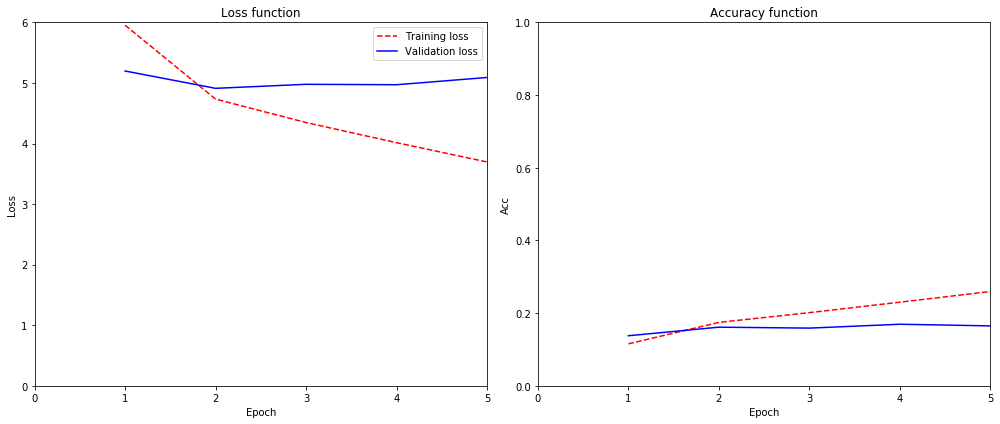

In [12]:
import matplotlib.pyplot as plt

# Make characteristics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

f = plt.figure(figsize=(14,6))

a0 = f.add_subplot(121)
a0.plot(epoch_count, training_loss, 'r--', label="Training loss")
a0.plot(epoch_count, validation_loss, 'b-', label="Validation loss")
a0.legend()
a0.set_title("Loss function")
a0.set_xlabel("Epoch")
plt.xlim(0, epochs)
a0.set_ylabel("Loss")
plt.ylim(0, np.ceil(max(training_loss)))

a1 = f.add_subplot(122)
a1.plot(epoch_count, training_acc, 'r--', label="Training acc")
a1.plot(epoch_count, validation_acc, 'b-', label="Validation acc")
a1.set_title("Accuracy function")
a1.set_xlabel("Epoch")
plt.xlim(0, epochs)
a1.set_ylabel("Acc")
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [13]:
seed = dataset.get_random_sequence()
print("Generating with seed:",seed, "\n")
generated_text = generate_text(model.model, seed, words_amount=50)
print(generated_text)

Generating with seed: needs to be confirmed with a handshake . will she shake 

trial, said k, as he was, as he was, he had not seen the two gentlemen, he had already forgotten, he was at first, he had to admit that he was not at all, as he could see what he was saying
